In [1]:
import torch
import cv2
import random
import time
import numpy as np
import matplotlib.pyplot as plt

import diff_gaussian_rasterization as dg

from gaussian_splatting.colmap import parse_cameras, parse_images, parse_points3d, clean_text
from gaussian_splatting.model.view import View, Cloud

In [2]:
dataset = "hotdog"

In [3]:
# parsing colmap output
with open(f"../data/{dataset}/cameras.txt", "r")  as f:
    cameras = parse_cameras(clean_text(f.readlines()))

with open(f"../data/{dataset}/points3D.txt", "r")  as f:
    points3d = parse_points3d(clean_text(f.readlines()))

with open(f"../data/{dataset}/images.txt", "r")  as f:
    images = parse_images(clean_text(f.readlines()), cameras, points3d)

# loading original images as nd arrays
original_images = {}
for image in images.values():
    im = cv2.imread(f"../data/{dataset}/images/{image.name}")[:, :, ::-1] / 255
    original_images[image.idx] = im

In [4]:
# loading the point cloud
cloud = Cloud(points3d.values())
cloud

In [5]:
# creating some views
views = [View.from_image(image) for image in images.values()]
views[:4]

In [6]:
# gaussian model from view
def create_model(view: View):
    configuration = dg.GaussianRasterizationSettings(
        image_height=view.height,
        image_width=view.width,
        tanfovx=np.tan(view.fovx/2),
        tanfovy=np.tan(view.fovy/2),
        bg=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"),
        scale_modifier=1.,
        viewmatrix=torch.tensor(view.viewmatrix(False).T, dtype=torch.float, device="cuda"),
        projmatrix=torch.tensor(view.viewmatrix(False).T @ view.projmatrix(znear=1).T, dtype=torch.float, device="cuda"),
        sh_degree=0,
        campos=torch.tensor(view.position, dtype=torch.float, device="cuda"),
        prefiltered=False,
        debug=False
    )
    return dg.GaussianRasterizer(configuration)

models: list[tuple[dg.GaussianRasterizer, View]] = [(create_model(view), view) for view in views]

In [7]:
# train/test splitting
random.seed(42)
random.shuffle(models)
train_split = 0.7
dataset_size = len(models)
train = models[:int(dataset_size*train_split)]
test = models[int(dataset_size*train_split):]

In [8]:
# create parameters from point cloud
number_points = len(cloud.points)
data = dict(
    means3D=torch.tensor(cloud.points_positions(), dtype=torch.float, device="cuda", requires_grad=True),
    means2D=torch.zeros((number_points, 3), dtype=torch.float, device="cuda", requires_grad=True),
    shs=torch.tensor(cloud.points_colors(), dtype=torch.float, device="cuda", requires_grad=True),
    opacities=torch.ones([number_points, 1], dtype=torch.float, device="cuda", requires_grad=True),
    scales=torch.tensor([[.01, .01, .01]] * number_points, dtype=torch.float, device="cuda", requires_grad=True),
    rotations=torch.tensor([[1, 0, 0, 0]] * number_points, dtype=torch.float, device="cuda", requires_grad=True),
)

In [9]:
def compare(model, view):
    _img, _ = model(**data)
    npimg = _img.cpu().detach().numpy().transpose([1, 2, 0])
    orig_img = original_images[view.image_index]
    plt.imshow(np.hstack([npimg, orig_img]))
    plt.show()

In [10]:
len(train), len(test)

(68, 30)

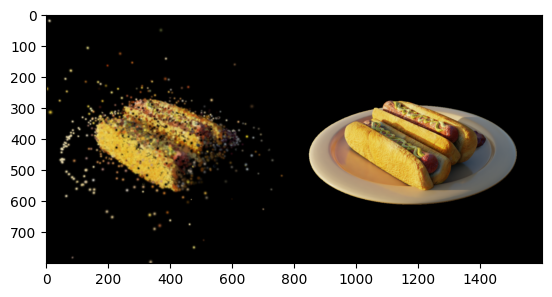

In [11]:
compare(*test[1])

In [12]:
over_reconstruction_scaling_factor = 1.6 # \phi
opacity_threshold = 0.005
positional_threshold = 2e-4 # \tau_pos
reconstruction_threshold = 0.05

def quaternion_to_rotation_matrix(quat):
    """ Convert a quaternion into a rotation matrix. """
    q0, q1, q2, q3 = quat.unbind(-1)
    rot_matrix = torch.stack([
        1 - 2*q2*q2 - 2*q3*q3, 2*q1*q2 - 2*q3*q0, 2*q1*q3 + 2*q2*q0,
        2*q1*q2 + 2*q3*q0, 1 - 2*q1*q1 - 2*q3*q3, 2*q2*q3 - 2*q1*q0,
        2*q1*q3 - 2*q2*q0, 2*q2*q3 + 2*q1*q0, 1 - 2*q1*q1 - 2*q2*q2
    ], dim=-1).reshape(-1, 3, 3)
    return rot_matrix

def rotate_points(scales, rotations, points):
    scaled = scales * points
    quaternions = rotations / rotations.norm(dim=1, keepdim=True)
    rot_matrices = quaternion_to_rotation_matrix(quaternions)
    rotated_points = torch.bmm(rot_matrices, scaled.unsqueeze(-1)).squeeze(-1)
    return rotated_points

def adaptive_density_control(means3D, means2D, shs, opacities, scales, rotations):
    almost_transparent = (opacities < opacity_threshold).squeeze()
    needs_adapting = means2D.grad.square().sum(dim=1).sqrt() > positional_threshold
    under_reconstructed = needs_adapting & (scales.square().sum(dim=1).sqrt() < reconstruction_threshold)
    over_reconstructed = needs_adapting & (scales.square().sum(dim=1).sqrt() >= reconstruction_threshold)

    print(f"out of {means3D.shape[0]} gaussians, {needs_adapting.sum()} need adapting")
    print(f"out of those {needs_adapting.sum()}, {under_reconstructed.sum()} are under-reconstructed")
    print(f"out of those {needs_adapting.sum()}, {over_reconstructed.sum()} are over-reconstructed")

    filter_points = (
        almost_transparent|
        needs_adapting
    )

    # lets double gaussians that are under_reconstructed
    under_reconstructed_means3D = torch.vstack([
        means3D[under_reconstructed], 
        means3D[under_reconstructed] + means3D.grad[under_reconstructed]
    ])
    under_reconstructed_means2D = torch.vstack([means2D[under_reconstructed]] * 2)
    under_reconstructed_scales = torch.vstack([scales[under_reconstructed]] * 2)
    under_reconstructed_opacities = torch.vstack([opacities[under_reconstructed]] * 2)
    under_reconstructed_shs = torch.vstack([shs[under_reconstructed]] * 2)
    under_reconstructed_rotations = torch.vstack([rotations[under_reconstructed]] * 2)

    # lets double gaussians that are very over_reconstructed

    # sample from gaussian (0, 1 distribution) 
    first_set_points = torch.normal(0, 1, size=(over_reconstructed.sum(), 3)).cuda()
    first_rotated = rotate_points(scales[over_reconstructed], rotations[over_reconstructed], first_set_points)

    second_set_points = torch.normal(0, 1, size=(over_reconstructed.sum(), 3)).cuda()
    second_rotated = rotate_points(scales[over_reconstructed], rotations[over_reconstructed], second_set_points)
    
    over_reconstructed_means3D = torch.vstack([
        means3D[over_reconstructed] + first_rotated, 
        means3D[over_reconstructed] + second_rotated
    ])
    over_reconstructed_means2D = torch.vstack([means2D[over_reconstructed]] * 2)
    over_reconstructed_scales = torch.vstack([scales[over_reconstructed]] * 2) / over_reconstruction_scaling_factor
    over_reconstructed_opacities = torch.vstack([opacities[over_reconstructed]] * 2)
    over_reconstructed_shs = torch.vstack([shs[over_reconstructed]] * 2)
    over_reconstructed_rotations = torch.vstack([rotations[over_reconstructed]] * 2)

    # stacking everything
    new_means3D = torch.vstack([    means3D[~filter_points],        over_reconstructed_means3D,     under_reconstructed_means3D])
    new_means2D = torch.vstack([    means2D[~filter_points],        over_reconstructed_means2D,     under_reconstructed_means2D])
    new_scales = torch.vstack([     scales[~filter_points],         over_reconstructed_scales,      under_reconstructed_scales])
    new_opacities = torch.vstack([  opacities[~filter_points],      over_reconstructed_opacities,   under_reconstructed_opacities])
    new_shs = torch.vstack([        shs[~filter_points],            over_reconstructed_shs,         under_reconstructed_shs])
    new_rotations = torch.vstack([  rotations[~filter_points],      over_reconstructed_rotations,   under_reconstructed_rotations])
    
    return dict(
        means3D=new_means3D.detach().requires_grad_(),
        means2D=new_means2D.detach().requires_grad_(),
        scales=new_scales.detach().requires_grad_(),
        opacities=new_opacities.detach().requires_grad_(),
        shs=new_shs.detach().requires_grad_(),
        rotations=new_rotations.detach().requires_grad_(),
    )

In [13]:
from gaussian_splatting.loss import DSSIM

ssim_loss = DSSIM
l1_loss = lambda img1, img2: torch.abs(img1 - img2).mean()

In [14]:
# putting images in the gpu
original_images_gpu = {
    key: torch.tensor(value, dtype=torch.float, device="cuda").permute(2, 0, 1)
    for key, value in original_images.items()
}

images = [*original_images_gpu.values()]

In [15]:
_lambda = 0.2
learning_rate = 1e-4

criterion = lambda img1, img2: (1 - _lambda) * l1_loss(img1, img2) + _lambda * ssim_loss(img1, img2)
# initial optimizer
create_optimizer = lambda variables: torch.optim.Adam(variables, learning_rate)
optimizer = create_optimizer(data.values())
train_loss = []
test_loss = []
for epoch in range(1, 200):
    s = time.perf_counter_ns()
    optimizer.zero_grad()
    epoch_train_loss = 0
    
    random.shuffle(train)
    for model, view in train:
        original_img = original_images_gpu[view.image_index]
        out_img, idx = model(**data)
        loss = criterion(original_img, out_img)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_train_loss /= len(train)
    train_loss.append(epoch_train_loss)

    epoch_loss = 0
    for model, view in test:
        with torch.no_grad():
            original_img = original_images_gpu[view.image_index]
            out_img, d = model(**data)
            loss = criterion(original_img, out_img)
            epoch_loss += loss.item()

    epoch_loss /= len(test)
    test_loss.append(epoch_loss)

    if epoch % 100 == 0:
        data = adaptive_density_control(**data)
        optimizer = create_optimizer(data.values())

    print(f"{epoch:4} loss: {epoch_loss:.6f}")


   1 loss: 0.132336
   2 loss: 0.116781
   3 loss: 0.102664


KeyboardInterrupt: 

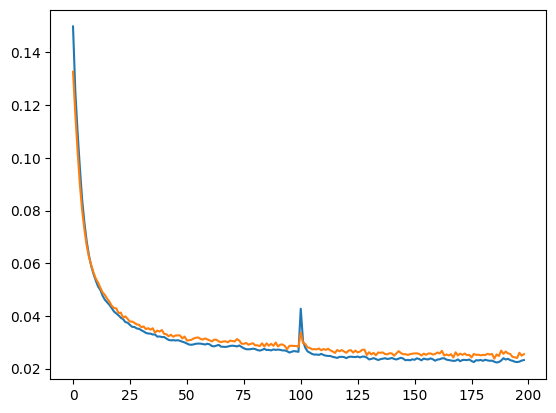

In [ ]:
plt.plot(train_loss)
plt.plot(test_loss)

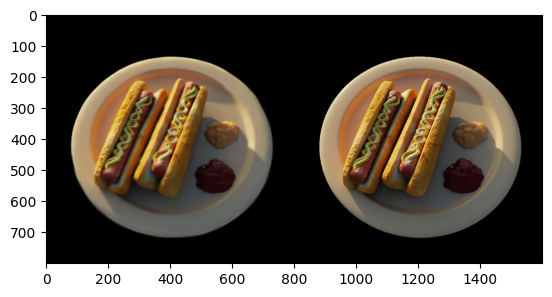

In [ ]:
compare(*test[0])

# saving the trained model

In [ ]:
import pickle
with open(f"../models/{dataset}.pkl", "wb") as f:
    pickle.dump({
        key: value.cpu()
        for key, value in data.items()
    }, f)

# analysing execution bottlenecks

In [ ]:
import time
model, view = models[0]
original_img = original_images_gpu[view.image_index]
out_img, d = model(**data)

N = 100

s = time.perf_counter_ns()
for _ in range(N):
    l1_loss(original_img, out_img)
l1_time = time.perf_counter_ns() - s

s = time.perf_counter_ns()
for _ in range(N):
    ssim_loss(original_img, out_img)
ssim_time = time.perf_counter_ns() - s

print(f"f1 loss took on average {l1_time/N*1e-6} ms")
print(f"ssim loss took on average {ssim_time/N*1e-6} ms")

f1 loss took on average 0.0443998 ms
ssim loss took on average 1.8920954799999998 ms
